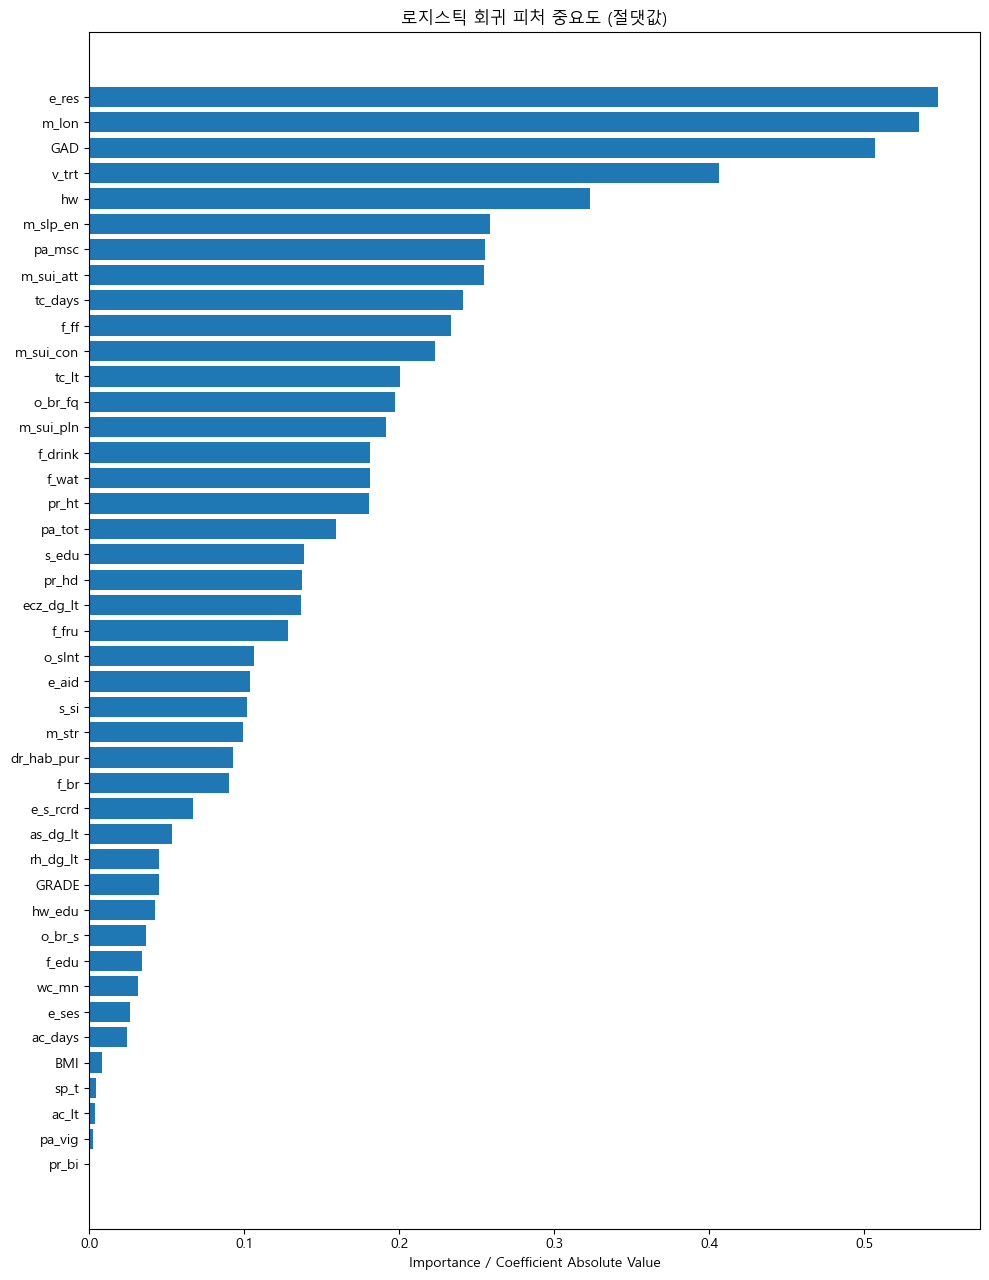

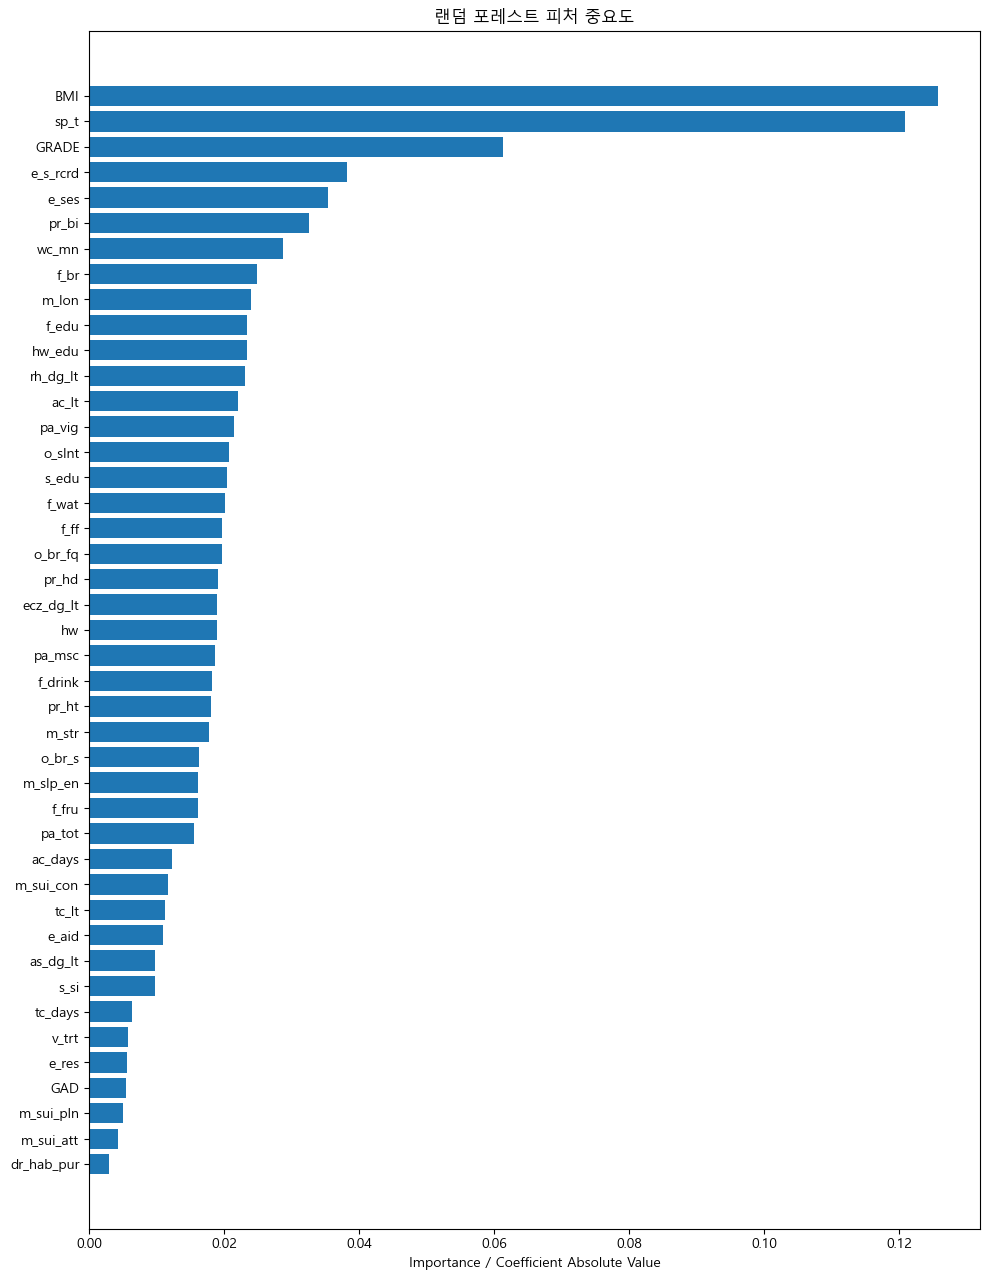

C:\Users\123cl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [17:56:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


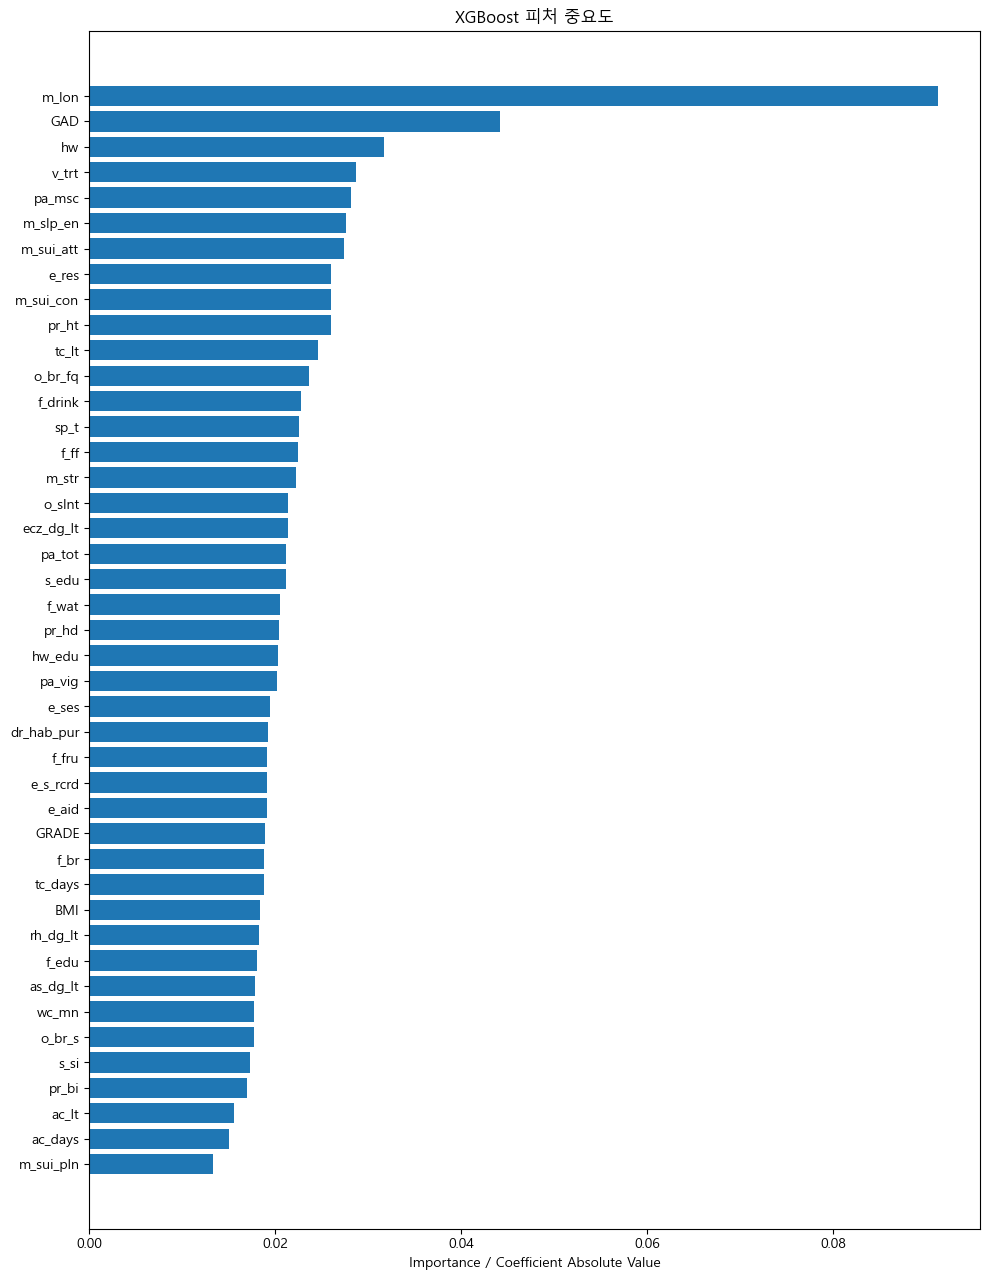

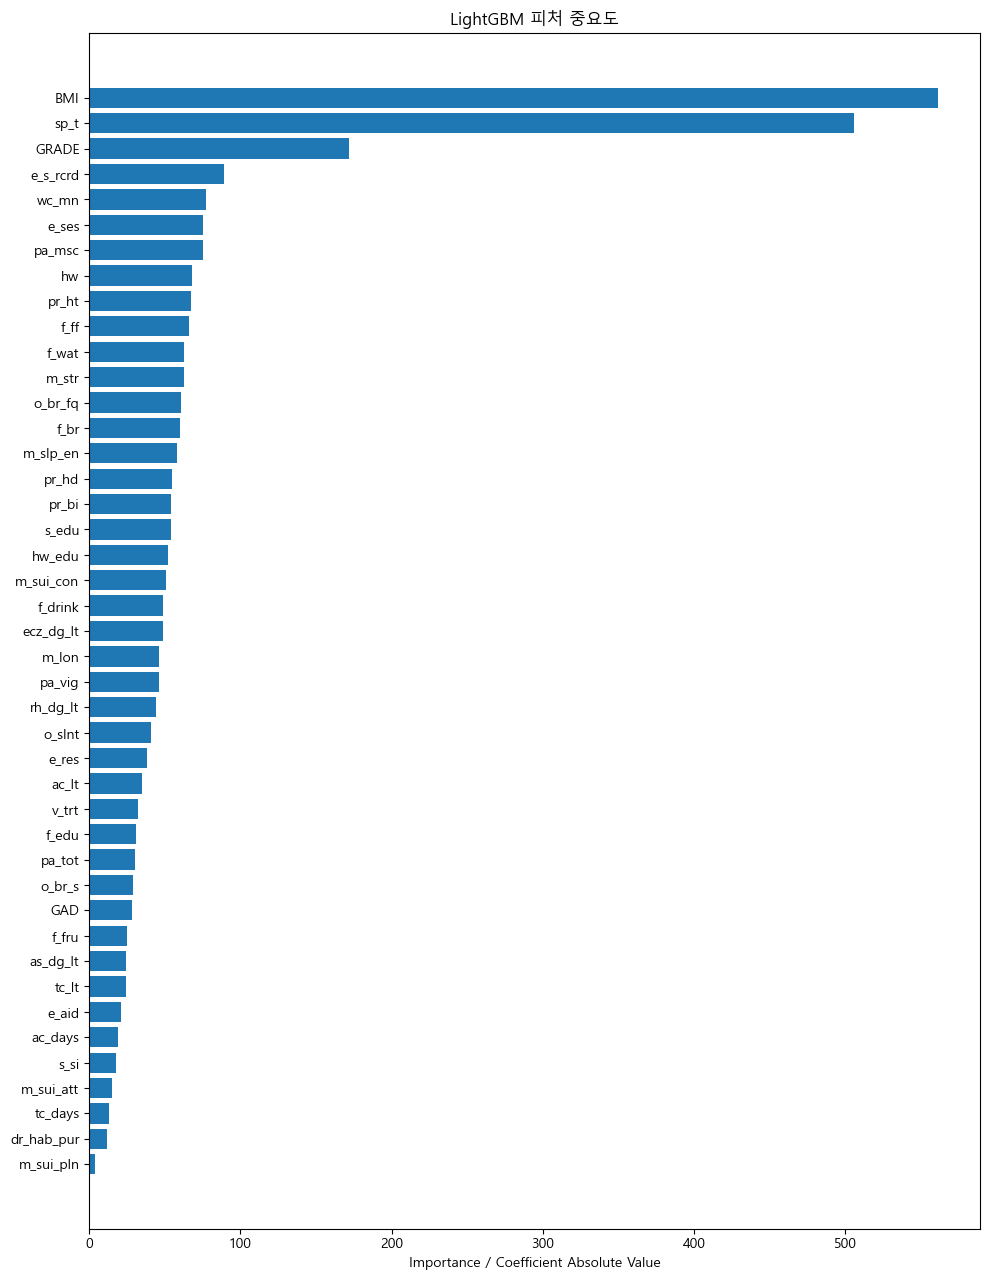

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm 

#폰트
def set_korean_font():
    font_name = None
    for font in fm.fontManager.ttflist:
        if 'Malgun Gothic' in font.name:
            font_name = font.name
            break
        elif 'AppleGothic' in font.name:
            font_name = font.name
            break
        elif 'NanumGothic' in font.name:
            font_name = font.name
            break
    
    if font_name:
        plt.rcParams['font.family'] = font_name
        plt.rcParams['axes.unicode_minus'] = False

set_korean_font() 

df = pd.read_csv("data/all_m.csv", encoding='ISO-8859-1')

#피처 및 타겟 지정
feature_columns = ["GRADE", "e_s_rcrd", "e_ses", "e_res", "e_aid",
                   "pr_ht", "pr_bi", "pr_hd", "BMI", "wc_mn", "f_br", "f_fru", "f_drink", "f_ff", "f_edu", "f_wat",
                   "pa_tot", "pa_vig", "pa_msc", "o_br_fq", "o_br_s", "o_slnt", "hw", "hw_edu", "as_dg_lt", "rh_dg_lt",
                   "ecz_dg_lt", "v_trt", "ac_lt", "ac_days", "tc_lt", "tc_days", "s_si", "s_edu", "dr_hab_pur", "sp_t",
                   "m_slp_en", "m_str", "m_lon", "GAD", "m_sui_con", "m_sui_pln", "m_sui_att"]


features = df[feature_columns].copy()
target = df["SP"].copy()

#이진 변수 결측치 대체 (최빈값)
binary_cols = ["e_s_rcrd", "e_ses", "e_res", "e_aid", "pr_ht", "pr_bi", "pr_hd",
               "f_br", "f_fru", "f_drink", "f_ff", "f_edu", "f_wat",
               "pa_tot", "pa_vig", "pa_msc", "o_br_fq", "o_br_s", "o_slnt", "hw", "hw_edu",
               "as_dg_lt", "rh_dg_lt", "ecz_dg_lt", "v_trt", "ac_lt", "tc_lt", "s_si", "s_edu",
               "dr_hab_pur", "m_sui_con", "m_sui_pln", "m_sui_att"]

for col in binary_cols:
    if col in features.columns:
        if features[col].isnull().all():
            features[col] = features[col].fillna(0)
        else:
            mode_val = features[col].mode(dropna=True)
            fillv = mode_val.iloc[0] if not mode_val.empty else 0
            features[col] = features[col].fillna(fillv)


#범주형 변수 원-핫 인코딩
features = pd.get_dummies(features, drop_first=True, dummy_na=False)




temp_df = pd.concat([features, target], axis=1)
temp_df.dropna(inplace=True)

features = temp_df.drop("SP", axis=1)
target = temp_df["SP"]


numeric_cols = features.select_dtypes(include=np.number).columns
scaler = StandardScaler()
features_scaled = features.copy()



def plot_all_features(series, title):
    sorted_series_for_plot = series.sort_values(ascending=True)
    plt.figure(figsize=(10, max(6, 0.30 * len(sorted_series_for_plot))))
    plt.barh(sorted_series_for_plot.index, sorted_series_for_plot.values)
    plt.xlabel('Importance / Coefficient Absolute Value')
    plt.title(title)
    plt.tight_layout()
    plt.show()

#로지스틱 회귀
lr = LogisticRegression(max_iter=2000, random_state=42, solver='liblinear')
lr.fit(features_scaled, target) # 스케일된 피처 사용
lr_coef = pd.Series(lr.coef_[0], index=features_scaled.columns)
# print("로지스틱 회귀 계수 (절댓값 기준 내림차순):") # 터미널 출력 최소화
# print(lr_coef.abs().sort_values(ascending=False))
plot_all_features(lr_coef.abs(), "로지스틱 회귀 피처 중요도 (절댓값)")

#랜덤 포레스트
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(features, target) # 원본(원-핫 인코딩만 된) 피처 사용
rf_importances = pd.Series(rf.feature_importances_, index=features.columns)
# print("\n랜덤 포레스트 피처 임포턴스 (내림차순):")
# print(rf_importances.sort_values(ascending=False))
plot_all_features(rf_importances, "랜덤 포레스트 피처 중요도")

#XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_estimators=100)
xgb_model.fit(features, target) # 원본 피처 사용
xgb_importances = pd.Series(xgb_model.feature_importances_, index=features.columns)
# print("\nXGBoost 피처 임포턴스 (내림차순):")
# print(xgb_importances.sort_values(ascending=False))
plot_all_features(xgb_importances, "XGBoost 피처 중요도")

#LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42, n_estimators=100, verbose=-1)
lgb_model.fit(features, target) # 원본 피처 사용
lgb_importances = pd.Series(lgb_model.feature_importances_, index=features.columns)
# print("\nLightGBM 피처 임포턴스 (내림차순):")
# print(lgb_importances.sort_values(ascending=False))
plot_all_features(lgb_importances, "LightGBM 피처 중요도")


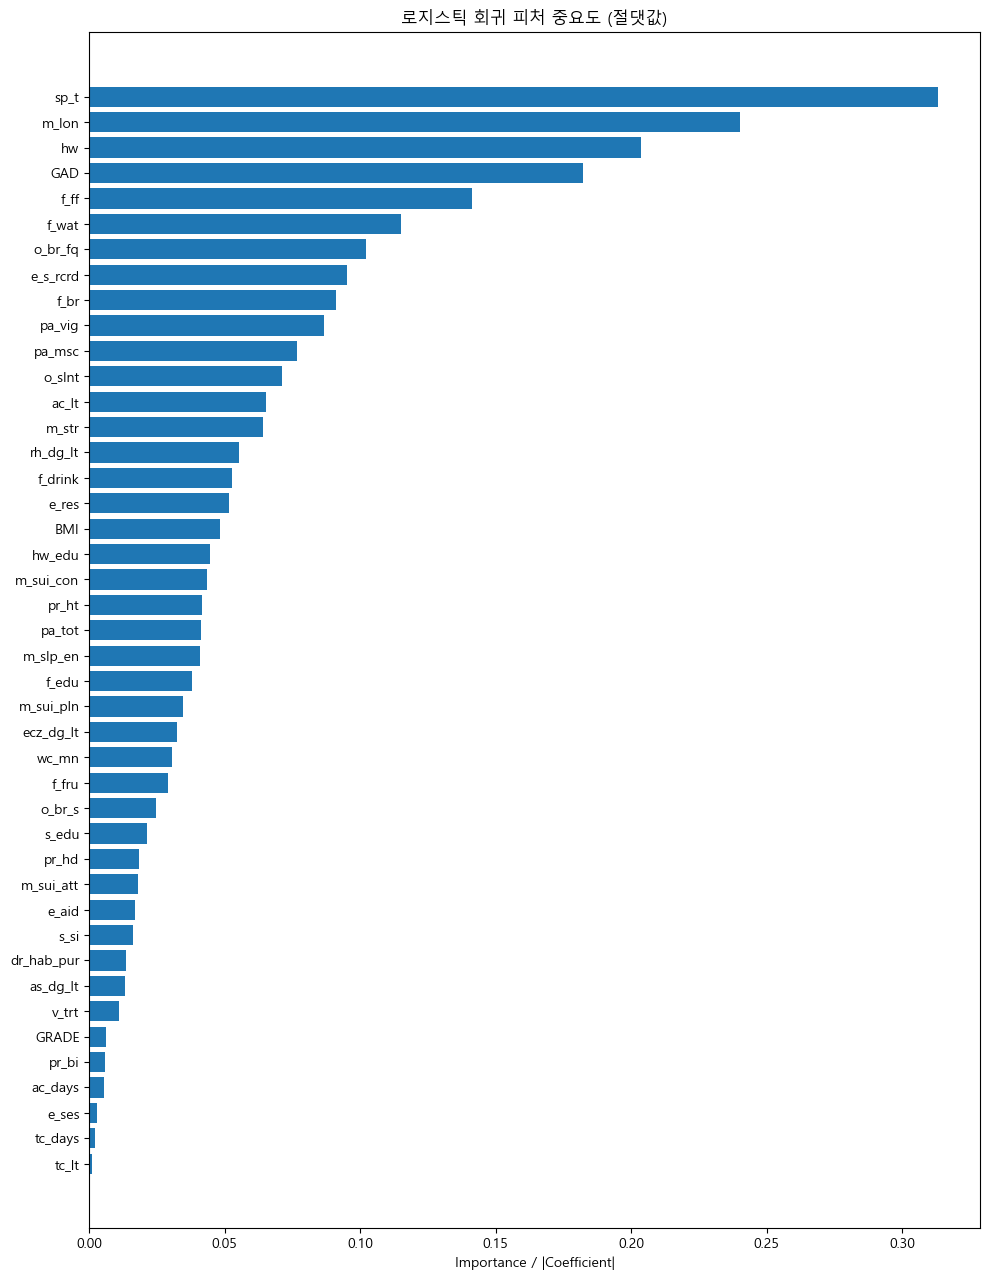

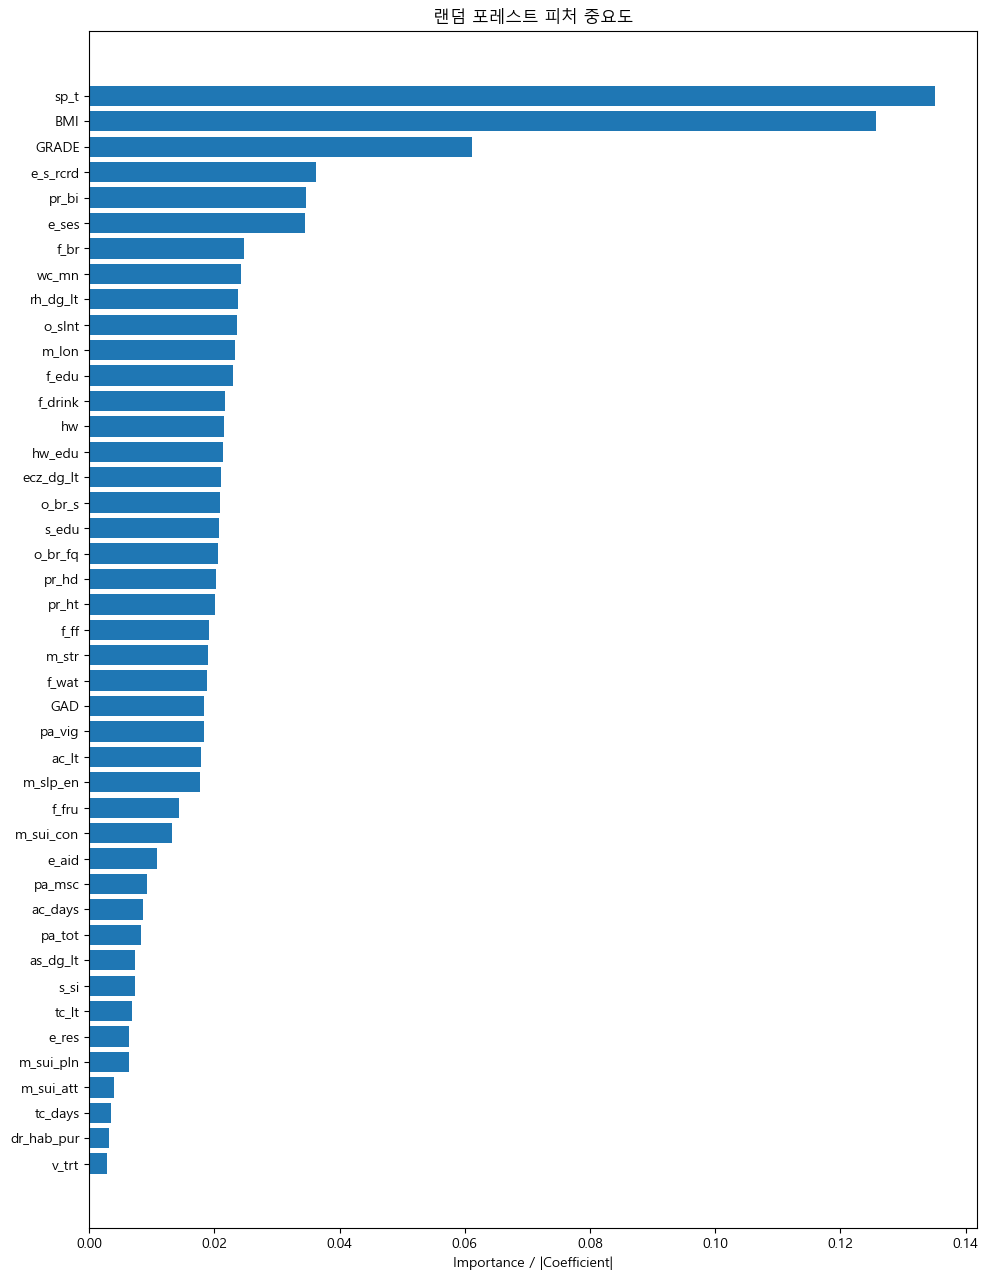

C:\Users\123cl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:04:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


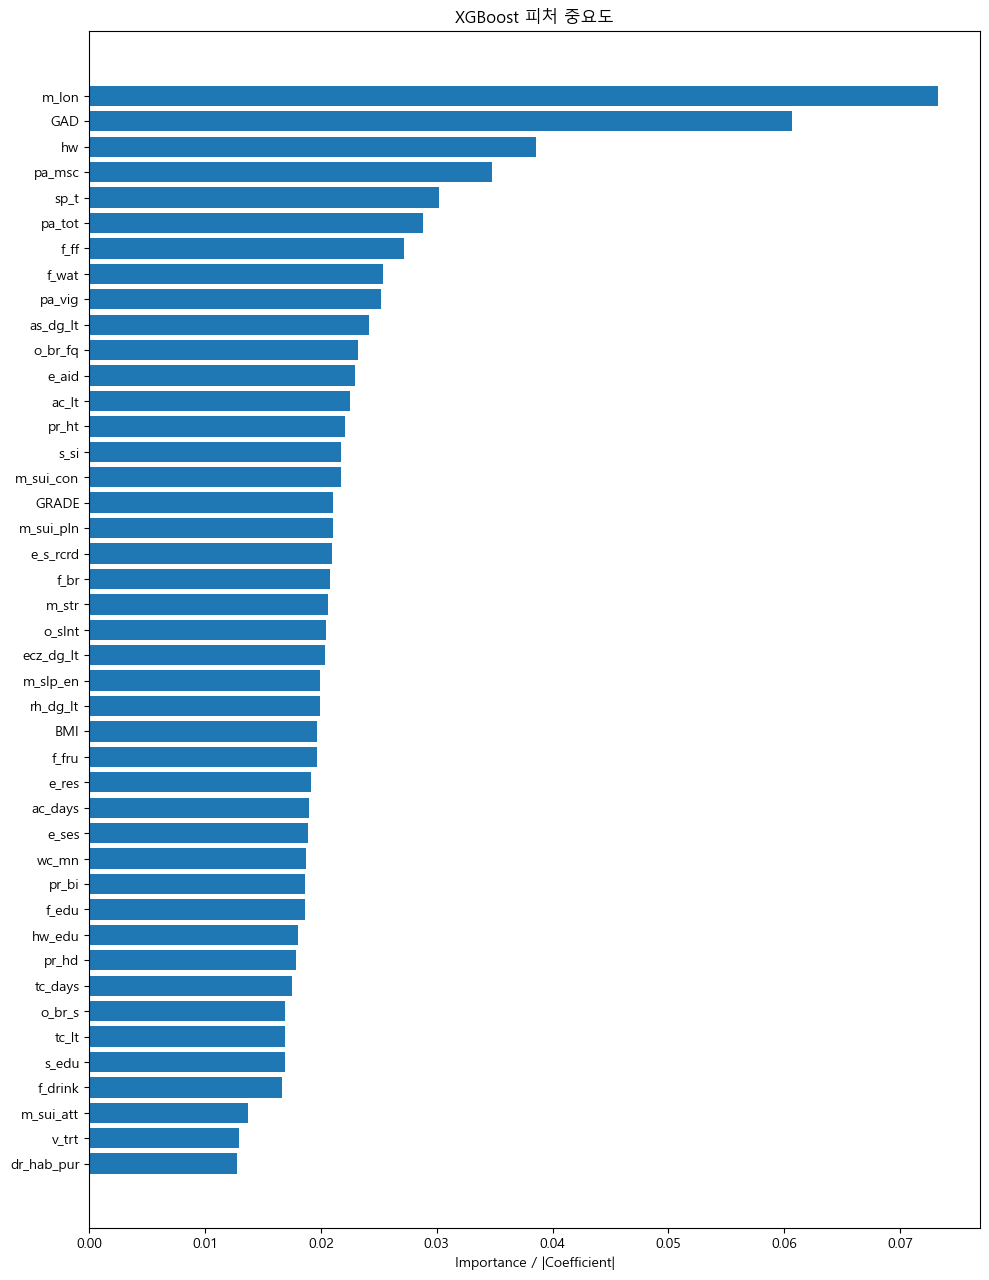

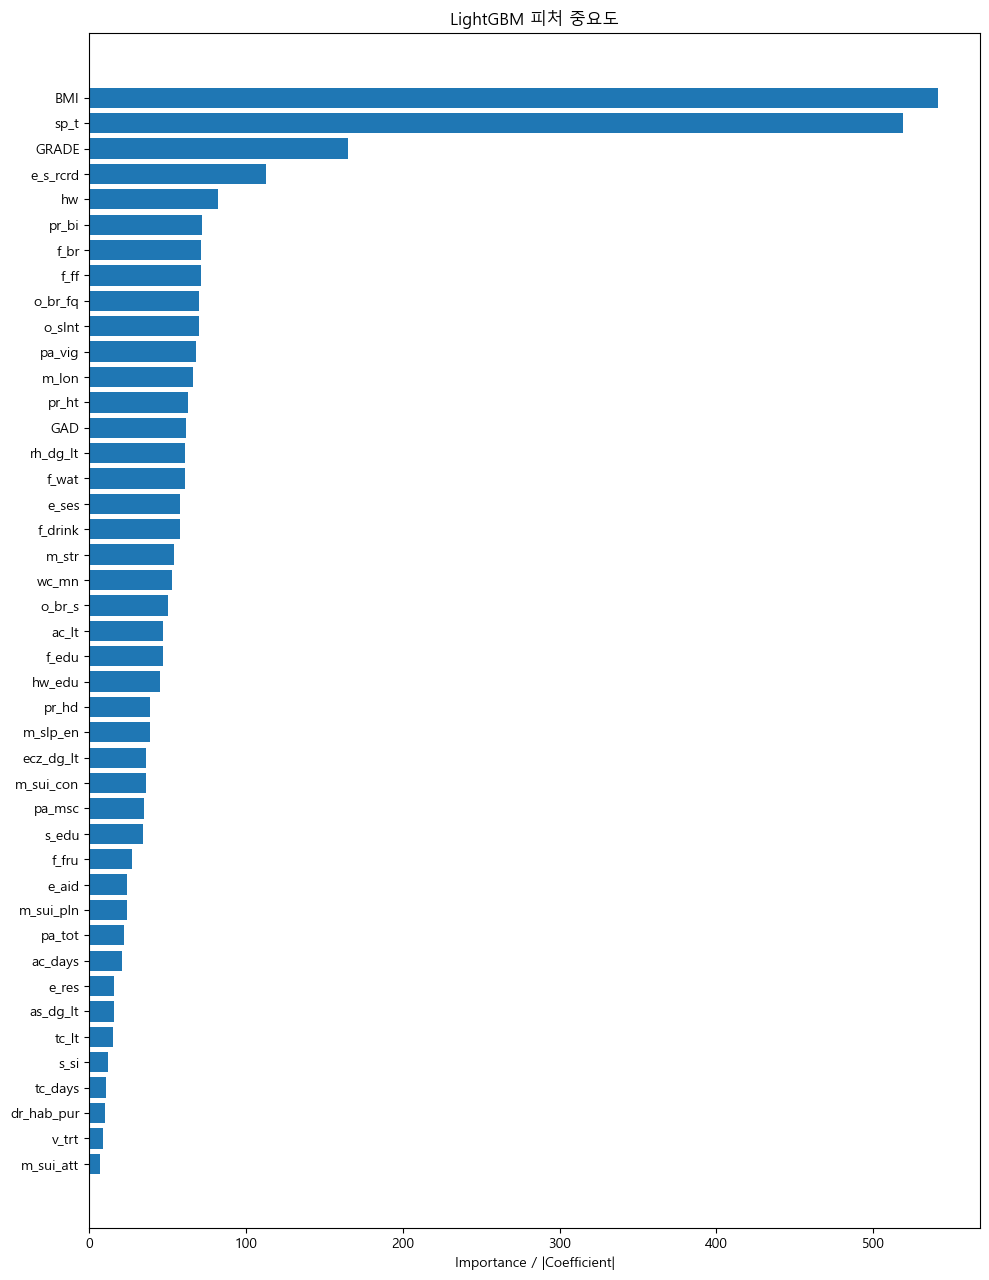

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


df = pd.read_csv("data/all_f.csv", encoding="ISO-8859-1")

#피처/타깃
feature_columns = ["GRADE", "e_s_rcrd", "e_ses", "e_res", "e_aid",
                   "pr_ht", "pr_bi", "pr_hd", "BMI", "wc_mn", "f_br", "f_fru", "f_drink", "f_ff", "f_edu", "f_wat",
                   "pa_tot", "pa_vig", "pa_msc", "o_br_fq", "o_br_s", "o_slnt", "hw", "hw_edu", "as_dg_lt", "rh_dg_lt",
                   "ecz_dg_lt", "v_trt", "ac_lt", "ac_days", "tc_lt", "tc_days", "s_si", "s_edu", "dr_hab_pur", "sp_t",
                   "m_slp_en", "m_str", "m_lon", "GAD", "m_sui_con", "m_sui_pln", "m_sui_att"]

features = df[feature_columns].copy()
target = df["SP"].copy()

#이진 변수 결측치 대체 (최빈값)
binary_cols = ["e_s_rcrd", "e_ses", "e_res", "e_aid", "pr_ht", "pr_bi", "pr_hd",
               "f_br", "f_fru", "f_drink", "f_ff", "f_edu", "f_wat",
               "pa_tot", "pa_vig", "pa_msc", "o_br_fq", "o_br_s", "o_slnt", "hw", "hw_edu",
               "as_dg_lt", "rh_dg_lt", "ecz_dg_lt", "v_trt", "ac_lt", "tc_lt", "s_si", "s_edu",
               "dr_hab_pur", "m_sui_con", "m_sui_pln", "m_sui_att"]

for col in binary_cols:
    if col in features:
        if features[col].isnull().all():
            features[col] = 0
        else:
            m = features[col].mode(dropna=True)
            features[col] = features[col].fillna(m.iloc[0] if not m.empty else 0)

#범주형: 원-핫
features = pd.get_dummies(features, drop_first=True, dummy_na=False)

#결측 제거
temp = pd.concat([features, target], axis=1).dropna()
features = temp.drop(columns=["SP"])
target = temp["SP"]

#스케일링(로지스틱용)
numeric_cols = features.select_dtypes(include=np.number).columns
scaler = StandardScaler()
features_scaled = features.copy()
features_scaled[numeric_cols] = scaler.fit_transform(features[numeric_cols])

# 플롯 함수
def plot_all_features(series, title):
    s = series.sort_values(ascending=True)
    plt.figure(figsize=(10, max(6, 0.30 * len(s))))
    plt.barh(s.index.astype(str), s.values)
    plt.xlabel("Importance / |Coefficient|")
    plt.title(title)
    plt.tight_layout()
    plt.show()

#로지스틱 (스케일 피처)
lr = LogisticRegression(max_iter=2000, random_state=42, solver="liblinear")
lr.fit(features_scaled, target)
lr_coef = pd.Series(lr.coef_[0], index=features_scaled.columns)
plot_all_features(lr_coef.abs(), "로지스틱 회귀 피처 중요도 (절댓값)")

#랜덤포레스트
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(features, target)
rf_imp = pd.Series(rf.feature_importances_, index=features.columns)
plot_all_features(rf_imp, "랜덤 포레스트 피처 중요도")

#XGBoost
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=42, n_estimators=100
)
xgb_model.fit(features, target)
xgb_imp = pd.Series(xgb_model.feature_importances_, index=features.columns)
plot_all_features(xgb_imp, "XGBoost 피처 중요도")

#LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42, n_estimators=100, verbose=-1)
lgb_model.fit(features, target)
lgb_imp = pd.Series(lgb_model.feature_importances_, index=features.columns)
plot_all_features(lgb_imp, "LightGBM 피처 중요도")


In [ ]:
#모델 성능 출력_남성

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from pprint import pprint

#데이터 로드 및 전처리
df = pd.read_csv("data/all_m.csv", encoding='ISO-8859-1')

features = df[["m_lon", "sp_t", "hw", "pa_msc", "m_slp_en", "f_ff", "e_res", "o_br_fq", "f_wat",
              "f_drink", "pr_ht", "GRADE", "pa_tot", "GAD", "s_edu", "pr_hd", "m_sui_con",
              "tc_lt", "v_trt", "e_s_rcrd", "ecz_dg_lt", "tc_days", "f_fru", "f_br", "m_str",
              "o_slnt"]]
target = df["SP"]

#원-핫 인코딩
features = pd.get_dummies(features, drop_first=True)

#데이터 분할 (6:2:2)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#결측값 제거
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_val = X_val.dropna()
y_val = y_val.loc[X_val.index]
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

#데이터 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#하이퍼파라미터 설정
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "max_iter": [200, 500, 1000]
}

#로지스틱 회귀 모델 학습
lr_model = LogisticRegression(random_state=42)
grid_lr = GridSearchCV(lr_model, param_grid_lr, cv=10, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Logistic Regression - Best Parameters:")
pprint(grid_lr.best_params_)

#예측
best_lr = grid_lr.best_estimator_
val_preds = best_lr.predict(X_val)
test_preds = best_lr.predict(X_test)

#평가 지표 계산
val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds, average='macro')
recall = recall_score(y_test, test_preds, average='macro')
f1 = f1_score(y_test, test_preds, average='macro')

#AUC 계산
val_probs = best_lr.predict_proba(X_val)[:, 1]
test_probs = best_lr.predict_proba(X_test)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
test_auc = roc_auc_score(y_test, test_probs)


print("\nEvaluation Metrics:")
print("Validation Accuracy: {:.4f}".format(val_accuracy))
print("Test Accuracy: {:.4f}".format(test_accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Validation AUC: {:.4f}".format(val_auc))
print("Test AUC: {:.4f}".format(test_auc))

test_auc_lr = test_auc 

Logistic Regression - Best Parameters:
{'C': 0.01, 'max_iter': 200}

Evaluation Metrics:
Validation Accuracy: 0.7646
Test Accuracy: 0.7753
Precision: 0.6981
Recall: 0.5318
F1 Score: 0.5049
Validation AUC: 0.6724
Test AUC: 0.6945


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

# ===== 설정 =====
N_TOP_FEATURES = 30
N_ITER = 20  # RandomizedSearch 반복 수
TARGET_COL = "SP"
FEATURES_COLS = [
    "m_lon","sp_t","hw","pa_msc","m_slp_en","f_ff","e_res","o_br_fq","f_wat",
    "f_drink","pr_ht","GRADE","pa_tot","GAD","s_edu","pr_hd","m_sui_con",
    "tc_lt","v_trt","e_s_rcrd","ecz_dg_lt","tc_days","f_fru","f_br","m_str",
    "o_slnt"
]

# ===== 데이터 로드 =====
df = pd.read_csv("data/all_m.csv", encoding="ISO-8859-1")

# 필요한 컬럼만
df_selected = df[FEATURES_COLS + [TARGET_COL]].copy()

# 결측 제거
df_selected = df_selected.dropna()

# 분리
features = df_selected[FEATURES_COLS]
target = df_selected[TARGET_COL]

# 원-핫 인코딩
features = pd.get_dummies(features, drop_first=True)

# 학습/검증/테스트 분할 (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    features, target, test_size=0.4, random_state=42, stratify=target
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 임시 RF로 피처 중요도 → 상위 N개 선택 (N이 컬럼 수보다 크면 자동 조정)
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X_train, y_train)
importances = pd.Series(rf_temp.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_N = min(N_TOP_FEATURES, len(importances))
top_features = importances.head(top_N).index

# 선택 피처만 사용
X_train = X_train[top_features]
X_val = X_val[top_features]
X_test = X_test[top_features]

# 하이퍼파라미터 탐색 공간
param_dist_rf = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10, 15],
    "min_samples_leaf": [1, 2, 4, 6],
    "class_weight": [None, "balanced", "balanced_subsample"],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
}

# 랜덤 서치 (ROC-AUC 기준)
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
random_search_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist_rf,
    n_iter=N_ITER,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
    random_state=42,
)
random_search_rf.fit(X_train, y_train)

print("Random Forest - Best Parameters:")
pprint(random_search_rf.best_params_)

# 검증/테스트
best_rf = random_search_rf.best_estimator_

val_preds = best_rf.predict(X_val)
test_preds = best_rf.predict(X_test)

val_probs = best_rf.predict_proba(X_val)[:, 1]
test_probs = best_rf.predict_proba(X_test)[:, 1]

# 지표
val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds, average="macro")
recall = recall_score(y_test, test_preds, average="macro")
f1 = f1_score(y_test, test_preds, average="macro")
val_auc = roc_auc_score(y_val, val_probs)
test_auc = roc_auc_score(y_test, test_probs)

print("\nEvaluation Metrics:")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

test_auc_rf = test_auc


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Random Forest - Best Parameters:
{'bootstrap': False,
 'class_weight': None,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 400}

Evaluation Metrics:
Validation Accuracy: 0.7599
Test Accuracy: 0.7599
Precision: 0.8799
Recall: 0.5016
F1 Score: 0.4350
Validation AUC: 0.6703
Test AUC: 0.6884


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from pprint import pprint

# 파라미터
N_TOP_FEATURES = 25
N_ITER = 10

#데이터 로드
df = pd.read_csv("data/all_m.csv", encoding='ISO-8859-1')

features = df[["m_lon", "GAD", "hw", "pr_ht", "v_trt", "e_res", "pa_msc", "o_br_fq", "m_slp_en", 
               "m_sui_con","f_wat", "pa_tot", "sp_t"]]
target = df["SP"]

#원-핫 인코딩
features = pd.get_dummies(features, drop_first=True)

#데이터 분할
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42, stratify=target)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

#결측값 제거
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_val = X_val.dropna()
y_val = y_val.loc[X_val.index]
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

#Feature Selection
xgb_temp = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_temp.fit(X_train, y_train)
feature_importances = pd.Series(xgb_temp.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(N_TOP_FEATURES).index

X_train = X_train[top_features]
X_val = X_val[top_features]
X_test = X_test[top_features]

#하이퍼파라미터 범위
param_dist = {
    'n_estimators': randint(80, 200),
    'max_depth': [3, 5, 7],
    'learning_rate': uniform(0.01, 0.09),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2),
    'min_child_weight': randint(1, 8),
    'gamma': uniform(0, 0.2),
    'reg_alpha': uniform(0, 0.15),
    'reg_lambda': uniform(0, 0.15),
    'scale_pos_weight': [1, sum(y_train == 0) / sum(y_train == 1)] 
}

#RandomizedSearchCV
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=N_ITER, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=42
)
random_search.fit(X_train, y_train)

print("XGBoost - Best Parameters:")
pprint(random_search.best_params_)

#예측
best_xgb = random_search.best_estimator_
val_preds = best_xgb.predict(X_val)
test_preds = best_xgb.predict(X_test)

#평가 지표 계산
val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds, average='macro')
recall = recall_score(y_test, test_preds, average='macro')
f1 = f1_score(y_test, test_preds, average='macro')

#AUC 계산
val_probs = best_xgb.predict_proba(X_val)[:, 1]
test_probs = best_xgb.predict_proba(X_test)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
test_auc = roc_auc_score(y_test, test_probs)


print("\n🔹 Evaluation Metrics:")
print("Validation Accuracy: {:.4f}".format(val_accuracy))
print("Test Accuracy: {:.4f}".format(test_accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Validation AUC: {:.4f}".format(val_auc))
print("Test AUC: {:.4f}".format(test_auc))

test_auc_rf = test_auc

C:\Users\123cl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:15:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\123cl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:15:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Best Parameters:
{'colsample_bytree': 0.9570351922786028,
 'gamma': 0.03993475643167195,
 'learning_rate': 0.056281099457225044,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 180,
 'reg_alpha': 0.09113172778521575,
 'reg_lambda': 0.025578618553093728,
 'scale_pos_weight': 1,
 'subsample': 0.8026529922319734}

🔹 Evaluation Metrics:
Validation Accuracy: 0.7539
Test Accuracy: 0.7632
Precision: 0.6659
Recall: 0.5300
F1 Score: 0.5012
Validation AUC: 0.6743
Test AUC: 0.6558


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from pprint import pprint

# 파라미터
N_TOP_FEATURES = 25
N_ITER = 10

# 1. 데이터 로드
df = pd.read_csv("data/all_m.csv", encoding='ISO-8859-1')

features = df[["m_lon", "GAD", "hw", "v_trt", "pa_msc", "m_slp_en", "m_sui_att", "e_res",
              "m_sui_con", "pr_ht", "tc_lt", "o_br_fq", "f_drink", "sp_t", "f_ff", "m_str",
              "o_slnt", "ecz_dg_lt", "pa_tot", "s_edu", "f_wat", "pr_hd", "hw_edu", "pa_vig"]]
target = df["SP"]

# 2. 원-핫 인코딩
features = pd.get_dummies(features, drop_first=True)

# 3. 데이터 분할 (stratify 적용)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42, stratify=target)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 4. 결측값 제거
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_val = X_val.dropna()
y_val = y_val.loc[X_val.index]
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

# 5. Feature Selection (XGBoost로 상위 N_TOP_FEATURES 변수 선택)
xgb_temp = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_temp.fit(X_train, y_train)
feature_importances = pd.Series(xgb_temp.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(N_TOP_FEATURES).index

X_train = X_train[top_features]
X_val = X_val[top_features]
X_test = X_test[top_features]

# 6. 하이퍼파라미터 범위 (효율적이고 class_weight 지원)
param_dist = {
    'n_estimators': randint(80, 200),
    'max_depth': [3, 5, 7],
    'learning_rate': uniform(0.01, 0.09),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2),
    'min_child_weight': randint(1, 8),
    'gamma': uniform(0, 0.2),
    'reg_alpha': uniform(0, 0.15),
    'reg_lambda': uniform(0, 0.15),
    'scale_pos_weight': [1, sum(y_train == 0) / sum(y_train == 1)]  # 불균형 데이터 대응
}

# 7. RandomizedSearchCV로 빠르게 최적 탐색
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=N_ITER, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=42
)
random_search.fit(X_train, y_train)

print("🔹 XGBoost - Best Parameters:")
pprint(random_search.best_params_)

# 8. 예측
best_xgb = random_search.best_estimator_
val_preds = best_xgb.predict(X_val)
test_preds = best_xgb.predict(X_test)

# 9. 평가 지표 계산 (출력 부분 그대로 유지)
val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds, average='macro')
recall = recall_score(y_test, test_preds, average='macro')
f1 = f1_score(y_test, test_preds, average='macro')

# 🔹 AUC 계산
val_probs = best_xgb.predict_proba(X_val)[:, 1]
test_probs = best_xgb.predict_proba(X_test)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
test_auc = roc_auc_score(y_test, test_probs)

# 10. 결과 출력 (수정하지 않음)
print("\n🔹 Evaluation Metrics:")
print("Validation Accuracy: {:.4f}".format(val_accuracy))
print("Test Accuracy: {:.4f}".format(test_accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Validation AUC: {:.4f}".format(val_auc))
print("Test AUC: {:.4f}".format(test_auc))

test_auc_xgb = test_auc

C:\Users\123cl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:15:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\123cl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:15:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔹 XGBoost - Best Parameters:
{'colsample_bytree': 0.9570351922786028,
 'gamma': 0.03993475643167195,
 'learning_rate': 0.056281099457225044,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 180,
 'reg_alpha': 0.09113172778521575,
 'reg_lambda': 0.025578618553093728,
 'scale_pos_weight': 1,
 'subsample': 0.8026529922319734}

🔹 Evaluation Metrics:
Validation Accuracy: 0.7571
Test Accuracy: 0.7679
Precision: 0.6991
Recall: 0.5376
F1 Score: 0.5135
Validation AUC: 0.6824
Test AUC: 0.6678


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from lightgbm import LGBMClassifier, early_stopping as lgb_early_stopping
from scipy.stats import randint, uniform
from pprint import pprint

# 파라미터: 사용할 상위 변수 개수/탐색 반복 수
N_TOP_FEATURES = 30
N_ITER = 10

#데이터 로드
df = pd.read_csv("data/all_m.csv", encoding='ISO-8859-1')

features = df[["BMI", "sp_t", "GRADE", "e_s_rcrd", "f_wat", "pa_msc", "hw", "wc_mn"]]
target = df["SP"]

#원-핫 인코딩
features = pd.get_dummies(features, drop_first=True)

#데이터 분할
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42, stratify=target)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

#결측값 제거
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_val = X_val.dropna()
y_val = y_val.loc[X_val.index]
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

#Feature Selection
lgb_temp = LGBMClassifier(random_state=42, n_estimators=80, n_jobs=-1)
lgb_temp.fit(X_train, y_train)
feature_importances = pd.Series(lgb_temp.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(N_TOP_FEATURES).index

X_train = X_train[top_features]
X_val = X_val[top_features]
X_test = X_test[top_features]

#하이퍼파라미터
param_dist = {
    'n_estimators': randint(80, 200),
    'max_depth': [3, 5, -1],
    'learning_rate': uniform(0.01, 0.09),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2),
    'min_child_samples': randint(10, 21),
    'reg_alpha': uniform(0, 0.15),
    'reg_lambda': uniform(0, 0.15),
    'class_weight': [None, 'balanced']
}

#RandomizedSearchCV
lgb_model = LGBMClassifier(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(lgb_model, param_distributions=param_dist,
                                   n_iter=N_ITER, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

print("LightGBM - Best Parameters:")
pprint(random_search.best_params_)


best_lgb = LGBMClassifier(random_state=42, n_jobs=-1, **random_search.best_params_)
best_lgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb_early_stopping(15)]
)

#예측
val_preds = best_lgb.predict(X_val)
test_preds = best_lgb.predict(X_test)

#평가 지표 계산
val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds, average='macro')
recall = recall_score(y_test, test_preds, average='macro')
f1 = f1_score(y_test, test_preds, average='macro')

#AUC 계산
val_probs = best_lgb.predict_proba(X_val)[:, 1]
test_probs = best_lgb.predict_proba(X_test)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
test_auc = roc_auc_score(y_test, test_probs)


print("\nEvaluation Metrics:")
print("Validation Accuracy: {:.4f}".format(val_accuracy))
print("Test Accuracy: {:.4f}".format(test_accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Validation AUC: {:.4f}".format(val_auc))
print("Test AUC: {:.4f}".format(test_auc))

test_auc_lgb = test_auc 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
LightGBM - Best Parameters:
{'class_weight': None,
 'colsample_bytree': 0.9593085973720467,
 'learning_rate': 0.02650913108795474,
 'max_depth': 3,
 'min_child_samples': 14,
 'n_estimators': 182,
 'reg_alpha': 0.06687491292803867,
 'reg_lambda': 0.014996237372700432,
 'subsample': 0.8918497783931735}
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.62139	valid_0's binary_logloss: 0.535001

Evaluation Metrics:
Validation Accuracy: 0.7603
Test Accuracy: 0.7594
Precision: 0.3797
Recall: 0.5000
F1 Score: 0.4316
Validation AUC: 0.6214
Test AUC: 0.6130


C:\Users\123cl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#모델 성능 출력_여성

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from pprint import pprint
import numpy as np


df = pd.read_csv("data/all_f.csv", encoding='ISO-8859-1')


# 피처 및 타겟 지정
feature_names = ["sp_t", "m_lon", "hw", "GAD", "f_ff", "f_wat", "o_br_fq", "e_s_rcrd", "f_br",
                "pa_vig"]

    
features_df = df[feature_names].copy()
target = df["SP"].copy()

categorical_features = [col for col in ['e_s_rcrd', 'f_br'] if col in feature_names] 
numerical_features = [col for col in feature_names if col not in categorical_features]

#데이터 분할 (6:2:2)
X_train_df, X_temp_df, y_train, y_temp = train_test_split(
    features_df, target, test_size=0.4, random_state=42, stratify=target
)
X_val_df, X_test_df, y_val, y_test = train_test_split(
    X_temp_df, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

#결측값 처리
X_train_df = X_train_df.copy()
X_val_df = X_val_df.copy()
X_test_df = X_test_df.copy()

X_train_df.dropna(inplace=True)
y_train = y_train.loc[X_train_df.index]

X_val_df.dropna(inplace=True)
y_val = y_val.loc[X_val_df.index]

X_test_df.dropna(inplace=True)
y_test = y_test.loc[X_test_df.index]


#원-핫 인코딩  및 표준화 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)], 
    remainder='passthrough')


X_train = preprocessor.fit_transform(X_train_df)
X_val = preprocessor.transform(X_val_df)
X_test = preprocessor.transform(X_test_df)



#하이퍼파라미터 설정
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10, 100],
    "max_iter": [200, 500, 1000, 1500],
    "solver": ['liblinear', 'saga']
}

#로지스틱 회귀 모델 학습
lr_model = LogisticRegression(random_state=42)

grid_lr = GridSearchCV(lr_model, param_grid_lr, cv=10, scoring='roc_auc', n_jobs=-1) 
grid_lr.fit(X_train, y_train)

print("Logistic Regression - Best Parameters:")
pprint(grid_lr.best_params_)


#예측
best_lr = grid_lr.best_estimator_
val_preds = best_lr.predict(X_val)
test_preds = best_lr.predict(X_test)

# 평가 지표 계산
val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds, average='macro', zero_division=0)
recall = recall_score(y_test, test_preds, average='macro', zero_division=0)
f1 = f1_score(y_test, test_preds, average='macro', zero_division=0)

#AUC 계산
val_probs = best_lr.predict_proba(X_val)[:, 1]
test_probs = best_lr.predict_proba(X_test)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
test_auc = roc_auc_score(y_test, test_probs)



print("\nEvaluation Metrics:")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision (Macro): {precision:.4f}")
print(f"Test Recall (Macro): {recall:.4f}")
print(f"Test F1 Score (Macro): {f1:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

test_auc_lr = test_auc

Logistic Regression - Best Parameters:
{'C': 0.01, 'max_iter': 200, 'solver': 'saga'}

Evaluation Metrics:
Validation Accuracy: 0.6930
Test Accuracy: 0.7051
Test Precision (Macro): 0.6582
Test Recall (Macro): 0.5752
Test F1 Score (Macro): 0.5663
Validation AUC: 0.6860
Test AUC: 0.7055


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from pprint import pprint

df = pd.read_csv("data/all_f.csv", encoding='ISO-8859-1')

#피처 및 타겟 지정
features = df[["sp_t", "BMI", "GRADE", "e_s_rcrd", "e_ses", "pr_bi"]]
target = df["SP"]

#원-핫 인코딩
features = pd.get_dummies(features, drop_first=True)

#데이터 분할 (6:2:2)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#결측값 제거
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_val = X_val.dropna()
y_val = y_val.loc[X_val.index]
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

#데이터 표준화 (조건 동일하게 유지)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#하이퍼파라미터 설정
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

#모델 학습
rf_model = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=10, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Random Forest - Best Parameters:")
pprint(grid_rf.best_params_)

#예측
best_rf = grid_rf.best_estimator_
val_preds = best_rf.predict(X_val)
test_preds = best_rf.predict(X_test)

#평가 지표 계산
val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds, average='macro')
recall = recall_score(y_test, test_preds, average='macro')
f1 = f1_score(y_test, test_preds, average='macro')

#AUC 계산
val_probs = best_rf.predict_proba(X_val)[:, 1]
test_probs = best_rf.predict_proba(X_test)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
test_auc = roc_auc_score(y_test, test_probs)


print("\nEvaluation Metrics:")
print("Validation Accuracy: {:.4f}".format(val_accuracy))
print("Test Accuracy: {:.4f}".format(test_accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Validation AUC: {:.4f}".format(val_auc))
print("Test AUC: {:.4f}".format(test_auc))


🔹 Random Forest - Best Parameters:
{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

🔹 Evaluation Metrics:
Validation Accuracy: 0.6949
Test Accuracy: 0.6880
Precision: 0.6774
Recall: 0.5027
F1 Score: 0.4142
Validation AUC: 0.6387
Test AUC: 0.6275


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from pprint import pprint

#데이터 로드
df = pd.read_csv("data/all_f.csv", encoding='ISO-8859-1')

#피처 및 타겟 지정
features = df[["m_lon", "GAD", "hw", "f_ff", "sp_t", "pa_msc", "pa_vig"]]
target = df["SP"]

#원-핫 인코딩
features = pd.get_dummies(features, drop_first=True)

#데이터 분할 (6:2:2)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#결측값 제거
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_val = X_val.dropna()
y_val = y_val.loc[X_val.index]
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]


#하이퍼파라미터 설정
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

#모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=10, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("XGBoost - Best Parameters:")
pprint(grid_xgb.best_params_)

#예측
best_xgb = grid_xgb.best_estimator_
val_preds = best_xgb.predict(X_val)
test_preds = best_xgb.predict(X_test)

#평가 지표 계산
val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds, average='macro')
recall = recall_score(y_test, test_preds, average='macro')
f1 = f1_score(y_test, test_preds, average='macro')

#AUC 계산
val_probs = best_xgb.predict_proba(X_val)[:, 1]
test_probs = best_xgb.predict_proba(X_test)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
test_auc = roc_auc_score(y_test, test_probs)


print("\nEvaluation Metrics:")
print("Validation Accuracy: {:.4f}".format(val_accuracy))
print("Test Accuracy: {:.4f}".format(test_accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Validation AUC: {:.4f}".format(val_auc))
print("Test AUC: {:.4f}".format(test_auc))


XGBoost - Best Parameters:
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}

Evaluation Metrics:
Validation Accuracy: 0.7105
Test Accuracy: 0.6968
Precision: 0.6372
Recall: 0.5504
F1 Score: 0.5273
Validation AUC: 0.6909
Test AUC: 0.6664


C:\Users\123cl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from pprint import pprint

df = pd.read_csv("data/all_f.csv", encoding='ISO-8859-1')

#피처 및 타겟 지정
features = df[["BMI", "sp_t", "GRADE", "e_s_rcrd", "hw", "pr_bi", "f_br", "f_ff",
              "o_br_fq", "o_slnt"]]
target = df["SP"]

#원-핫 인코딩
features = pd.get_dummies(features, drop_first=True)

#데이터 분할 (6:2:2)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#결측값 제거
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_val = X_val.dropna()
y_val = y_val.loc[X_val.index]
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

#하이퍼파라미터 설정
param_grid_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, -1],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

#모델 학습
lgb_model = LGBMClassifier(random_state=42)
grid_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=10, scoring='accuracy', n_jobs=-1)
grid_lgb.fit(X_train, y_train)

print("LightGBM - Best Parameters:")
pprint(grid_lgb.best_params_)

#예측
best_lgb = grid_lgb.best_estimator_
val_preds = best_lgb.predict(X_val)
test_preds = best_lgb.predict(X_test)

#평가 지표 계산
val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds, average='macro')
recall = recall_score(y_test, test_preds, average='macro')
f1 = f1_score(y_test, test_preds, average='macro')

#AUC 계산
val_probs = best_lgb.predict_proba(X_val)[:, 1]
test_probs = best_lgb.predict_proba(X_test)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
test_auc = roc_auc_score(y_test, test_probs)


print("\nEvaluation Metrics:")
print("Validation Accuracy: {:.4f}".format(val_accuracy))
print("Test Accuracy: {:.4f}".format(test_accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Validation AUC: {:.4f}".format(val_auc))
print("Test AUC: {:.4f}".format(test_auc))


LightGBM - Best Parameters:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Evaluation Metrics:
Validation Accuracy: 0.6935
Test Accuracy: 0.6877
Precision: 0.6078
Recall: 0.5525
F1 Score: 0.5389
Validation AUC: 0.6553
Test AUC: 0.6394
